#final code

In [ ]:
!kaggle datasets download -d nikhilroxtomar/brain-tumor-segmentation -p /content
!unzip /content/brain-tumor-segmentation.zip -d /content

Streaming output truncated to the last 5000 lines.
  inflating: /content/images/2013.png  
  inflating: /content/images/2014.png  
  inflating: /content/images/2015.png  
  inflating: /content/images/2016.png  
  inflating: /content/images/2017.png  
  inflating: /content/images/2018.png  
  inflating: /content/images/2019.png  
  inflating: /content/images/202.png  
  inflating: /content/images/2020.png  
  inflating: /content/images/2021.png  
  inflating: /content/images/2022.png  
  inflating: /content/images/2023.png  
  inflating: /content/images/2024.png  
  inflating: /content/images/2025.png  
  inflating: /content/images/2026.png  
  inflating: /content/images/2027.png  
  inflating: /content/images/2028.png  
  inflating: /content/images/2029.png  
  inflating: /content/images/203.png  
  inflating: /content/images/2030.png  
  inflating: /content/images/2031.png  
  inflating: /content/images/2032.png  
  inflating: /content/images/2033.png  
  inflating: /content/images/20

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install opencv-python PyWavelets scikit-image tensorflow keras --quiet

import os
import glob
import numpy as np
import cv2
import pywt
import matplotlib.pyplot as plt

from skimage.metrics import structural_similarity as ssim

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 50.1 MB/s eta 0:00:00


In [ ]:
def load_image(img_path, target_size=(512,512)):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)  # BGR
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size, interpolation=cv2.INTER_LINEAR)
    img = img.astype(np.float32)/255.0
    return img  # shape(H,W,3)

def load_mask(mask_path, target_size=(512,512)):
    m = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    m = cv2.resize(m, target_size, interpolation=cv2.INTER_NEAREST)
    m = (m>127).astype(np.float32)
    return m  # shape(H,W)

In [ ]:
def query_deeplab(blackbox_model, img_np):
    """
    blackbox_model: loaded .keras or another TF model that outputs a single sigmoid channel
    img_np: (H,W,3) float
    returns a binary mask (H,W)
    """
    input_tensor = np.expand_dims(img_np, axis=0)  # (1,H,W,3)
    preds = blackbox_model.predict(input_tensor,verbose=0)
    # if model's output is shape (1,H,W,1), threshold:
    mask = (preds[0,...,0]>0.5).astype(np.float32)
    return mask

In [ ]:
def load_surrogate_unet(unet_weights_path, input_shape=(512,512,3)):
    """
    1) Build surrogate U-Net same structure
    2) Load weights
    3) Create feature_extractor model from a chosen layer
    """
    # Minimal 2D U-Net structure
    inputs = keras.Input(shape=input_shape)

    # encoder
    c1 = keras.layers.Conv2D(64,3,activation='relu',padding='same')(inputs)
    c1 = keras.layers.Conv2D(64,3,activation='relu',padding='same')(c1)
    p1 = keras.layers.MaxPooling2D()(c1)

    c2 = keras.layers.Conv2D(128,3,activation='relu',padding='same')(p1)
    c2 = keras.layers.Conv2D(128,3,activation='relu',padding='same')(c2)
    p2 = keras.layers.MaxPooling2D()(c2)

    c3 = keras.layers.Conv2D(256,3,activation='relu',padding='same')(p2)
    c3 = keras.layers.Conv2D(256,3,activation='relu',padding='same')(c3)
    p3 = keras.layers.MaxPooling2D()(c3)

    c4 = keras.layers.Conv2D(512,3,activation='relu',padding='same')(p3)
    c4 = keras.layers.Conv2D(512,3,activation='relu',padding='same')(c4)
    p4 = keras.layers.MaxPooling2D()(c4)

    # bottleneck
    c5 = keras.layers.Conv2D(1024,3,activation='relu',padding='same')(p4)
    c5 = keras.layers.Conv2D(1024,3,activation='relu',padding='same')(c5)

    # decoder
    u6 = keras.layers.Conv2DTranspose(512,2,strides=2,padding='same')(c5)
    u6 = keras.layers.concatenate([u6,c4])
    c6 = keras.layers.Conv2D(512,3,activation='relu',padding='same')(u6)
    c6 = keras.layers.Conv2D(512,3,activation='relu',padding='same')(c6)

    u7 = keras.layers.Conv2DTranspose(256,2,strides=2,padding='same')(c6)
    u7 = keras.layers.concatenate([u7,c3])
    c7 = keras.layers.Conv2D(256,3,activation='relu',padding='same')(u7)
    c7 = keras.layers.Conv2D(256,3,activation='relu',padding='same')(c7)

    u8 = keras.layers.Conv2DTranspose(128,2,strides=2,padding='same')(c7)
    u8 = keras.layers.concatenate([u8,c2])
    c8 = keras.layers.Conv2D(128,3,activation='relu',padding='same')(u8)
    c8 = keras.layers.Conv2D(128,3,activation='relu',padding='same')(c8)

    u9 = keras.layers.Conv2DTranspose(64,2,strides=2,padding='same')(c8)
    u9 = keras.layers.concatenate([u9,c1])
    c9 = keras.layers.Conv2D(64,3,activation='relu',padding='same')(u9)
    c9 = keras.layers.Conv2D(64,3,activation='relu',padding='same')(c9)

    outputs = keras.layers.Conv2D(1,1,activation='sigmoid')(c9)
    unet_model = keras.Model(inputs, outputs)

    # load weights
    unet_model.load_weights(unet_weights_path)
    print(f"Loaded Surrogate U-Net from {unet_weights_path}")

    return unet_model

In [ ]:
def dice_np(pred_mask, gt_mask, eps=1e-5):
    intersection = (pred_mask*gt_mask).sum()
    union = pred_mask.sum() + gt_mask.sum()
    return (2.0*intersection+eps)/(union+eps)

def ssim_color(orig, adv):
    # average channel-wise SSIM
    ssim_vals=[]
    for c in range(orig.shape[2]):
        ssim_vals.append(ssim(orig[:,:,c], adv[:,:,c], data_range=adv[:,:,c].max()-adv[:,:,c].min()))
    return np.mean(ssim_vals)

In [ ]:
def wavelet_decompose_3ch(img_np, wavelet='haar', level=2):
    coeffs_list=[]
    for c in range(3):
        cA = pywt.wavedec2(img_np[:,:,c], wavelet, level=level)
        coeffs_list.append(cA)
    return coeffs_list

def wavelet_reconstruct_3ch(coeffs_list, wavelet='haar'):
    channels=[]
    for cA in coeffs_list:
        rec = pywt.waverec2(cA, wavelet=wavelet)
        channels.append(rec)
    return np.stack(channels, axis=-1)

def flatten_coeffs_3ch(coeffs_list):
    param_vecs=[]
    struct_list=[]
    for cA in coeffs_list:
        approx=cA[0]
        details=cA[1:]
        flatten=[]
        for (h,v,d) in details:
            flatten.append(h.flatten())
            flatten.append(v.flatten())
            flatten.append(d.flatten())
        param_vec = np.concatenate(flatten)
        param_vecs.append(param_vec)
        struct_list.append(cA)
    big_param = np.concatenate(param_vecs)
    return struct_list, big_param

def rebuild_3ch_params(struct_list, param_vec, wavelet='haar'):
    new_coeffs=[]
    idx=0
    for cA in struct_list:
        approx = cA[0]
        details= cA[1:]
        total_sz=0
        for (h,v,d) in details:
            total_sz+=(h.size+v.size+d.size)
        cparam=param_vec[idx:idx+total_sz]
        idx+=total_sz

        offset=0
        detail_new=[]
        for (h,v,d) in details:
            sh=h.size; sv=v.size; sd=d.size
            hnew=cparam[offset:offset+sh].reshape(h.shape)
            offset+=sh
            vnew=cparam[offset:offset+sv].reshape(v.shape)
            offset+=sv
            dnew=cparam[offset:offset+sd].reshape(d.shape)
            offset+=sd
            detail_new.append((hnew,vnew,dnew))
        new_cA=[approx,*detail_new]
        new_coeffs.append(new_cA)
    rec_img = wavelet_reconstruct_3ch(new_cA for new_cA in new_coeffs)
    return rec_img

In [ ]:
def wavelet_attack_surrogate_roi(
    orig_img_np, gt_mask_np,
    blackbox_model,
    surrogate_feature_extractor,
    steps=50,
    alpha=0.02,
    ssim_thresh=0.95,
    feat_weight=5.0
):
    """
    Performs a wavelet-based adversarial attack where the perturbation is applied only
    to the ROI defined by the segmentation mask from the black-box model.

    Parameters:
      orig_img_np: Original input image (H,W,3) normalized to [0,1].
      gt_mask_np: Ground-truth mask (H,W).
      blackbox_model: Pre-trained segmentation model.
      surrogate_feature_extractor: Model to extract deep features from the image.
      steps: Number of iterations for perturbation.
      alpha: Standard deviation of the noise added in the wavelet domain.
      ssim_thresh: Minimum allowed SSIM to maintain image similarity.
      feat_weight: Weighting factor for the feature difference term.

    Returns:
      best_img: Adversarial image after the attack.
      best_dice: Dice score of the adversarial image.
    """
    # 1. Get ROI from the black-box segmentation model.
    seg_mask = query_deeplab(blackbox_model, orig_img_np)  # binary mask (H,W)
    seg_mask_3ch = np.stack([seg_mask]*3, axis=-1)         # expand to (H,W,3)

    # 2. Compute the baseline segmentation and Dice score.
    base_pred = query_deeplab(blackbox_model, orig_img_np)
    base_dice = dice_np(base_pred, gt_mask_np)
    print(f"Baseline Dice: {base_dice:.4f}")

    # 3. Extract surrogate features for the original image.
    orig_feat = surrogate_feature_extractor.predict(np.expand_dims(orig_img_np, axis=0))

    # 4. Perform wavelet decomposition and flatten the coefficients.
    structure, param_vec = flatten_coeffs_3ch(wavelet_decompose_3ch(orig_img_np))

    best_img  = orig_img_np.copy()
    best_vec  = param_vec.copy()
    best_dice = base_dice
    best_score= -base_dice  # Initialize best score (total score)

    for step in range(steps):
        # Add noise to the wavelet coefficient vector.
        candidate_vec = param_vec + np.random.normal(0, alpha, size=param_vec.shape)
        # Reconstruct candidate image from perturbed coefficients.
        candidate_wavelet_img = rebuild_3ch_params(structure, candidate_vec)
        candidate_wavelet_img = np.clip(candidate_wavelet_img, 0, 1)

        # 5. Apply the perturbation only within the ROI.
        candidate_img = orig_img_np + (candidate_wavelet_img - orig_img_np) * seg_mask_3ch
        candidate_img = np.clip(candidate_img, 0, 1)

        # 6. Check SSIM to ensure the candidate image is similar enough to the original.
        ssim_val = ssim_color(orig_img_np, candidate_img)
        if ssim_val < ssim_thresh:
            alpha *= 0.8  # Reduce the perturbation step if too aggressive.
            continue

        # 7. Evaluate the candidate using the Dice score.
        pred_mask = query_deeplab(blackbox_model, candidate_img)
        dice_val = dice_np(pred_mask, gt_mask_np)

        # 8. Compute surrogate feature difference.
        adv_feat  = surrogate_feature_extractor.predict(np.expand_dims(candidate_img, axis=0))
        feat_diff = np.mean((adv_feat - orig_feat)**2)

        # 9. Compute a total score: lower dice (i.e. worse segmentation) is better,
        #    combined with a weighted feature difference.
        total_score = - dice_val + feat_weight * feat_diff

        # 10. Update the best candidate if this one is better.
        if total_score > best_score:
            best_score = total_score
            best_dice  = dice_val
            best_img   = candidate_img.copy()
            best_vec   = candidate_vec.copy()

        if (step+1) % 10 == 0:
            print(f"Step {step+1}/{steps}: dice={dice_val:.4f}, ssim={ssim_val:.3f}, feat_diff={feat_diff:.6f}, total_score={total_score:.6f}")

    print(f"Final Adversarial Dice: {best_dice:.4f} (Baseline was {base_dice:.4f})")
    return best_img, best_dice


In [ ]:
"""
1) Load black-box model (deeplab).
2) Load surrogate & feature extractor.
3) Load a single .png + mask.
4) Run wavelet surrogate-based attack.
"""
# Load your black-box model
blackbox_model = keras.models.load_model('/content/drive/MyDrive/best_model_deeplab-v3.keras', compile=False)
blackbox_model.trainable = False


In [ ]:
# Load surrogate + feature
unet_model = load_surrogate_unet(
    unet_weights_path='/content/drive/MyDrive/best_unet(1).keras',
    input_shape=(512,512,3)
    )


Loaded Surrogate U-Net from /content/drive/MyDrive/best_unet(1).keras


In [ ]:
feature_layer_name='conv2d_transpose'
# create feature extractor
feature_extractor = Model(
    inputs=unet_model.input,
    outputs=unet_model.get_layer(feature_layer_name).output
)
print(f"Feature extractor created: layer={feature_layer_name}")


Feature extractor created: layer=conv2d_transpose


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Baseline Dice: 0.8959
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Step 10/10: dice=0.7988, ssim=0.989, feat_diff=0.000000, total_score=-0.798781
Final Adversarial Dice: 0.7988 (Baseline was 0.8959)


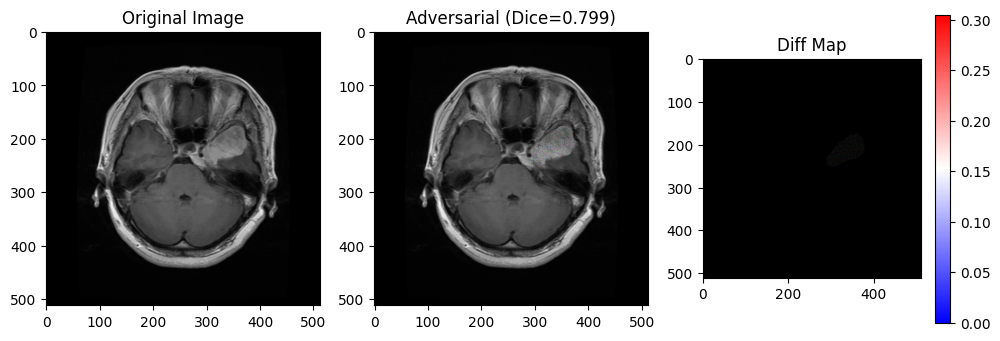

In [ ]:
# pick an example image & mask
img_path  = '/content/images/1.png'
mask_path = '/content/masks/1.png'

orig_img_np = load_image(img_path, (512,512))
gt_mask_np  = load_mask(mask_path, (512,512))

# run wavelet attack
adv_img, adv_dice = wavelet_attack_surrogate_roi(
    orig_img_np,
    gt_mask_np,
    blackbox_model=blackbox_model,
    surrogate_feature_extractor=feature_extractor,
    steps=10,
    alpha=0.09,
    ssim_thresh=0.70,
    feat_weight=20.0
)

# visualize
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(orig_img_np)
plt.title('Original Image')
plt.subplot(132)
plt.imshow(adv_img)
plt.title(f'Adversarial (Dice={adv_dice:.3f})')
plt.subplot(133)
diff = adv_img - orig_img_np
plt.imshow(diff, cmap='bwr')
plt.title('Diff Map')
plt.colorbar()
plt.show()


# boundray based

In [ ]:
def get_boundary_mask(seg_mask, kernel_size=3):
    """
    Computes a boundary mask from a binary segmentation mask using morphological operations.

    Parameters:
      seg_mask: Binary segmentation mask (H,W), values 0 or 1.
      kernel_size: Size of the structuring element for dilation/erosion.

    Returns:
      boundary: Binary mask (H,W) where boundaries are marked as 1.
    """
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    dilated = cv2.dilate(seg_mask.astype(np.uint8), kernel, iterations=3)
    eroded = cv2.erode(seg_mask.astype(np.uint8), kernel, iterations=3)
    boundary = dilated - eroded
    boundary = boundary.astype(np.float32)
    boundary[boundary > 0] = 1.0
    return boundary

def wavelet_attack_surrogate_boundary(
    orig_img_np, gt_mask_np,
    blackbox_model,
    surrogate_feature_extractor,
    steps=50,
    alpha=0.02,
    ssim_thresh=0.95,
    feat_weight=5.0,
    kernel_size=3  # for boundary extraction
):
    """
    Performs a wavelet-based adversarial attack where the perturbation is applied only
    to the boundary regions of the segmentation mask from the black-box model.

    Parameters:
      orig_img_np: Original input image (H,W,3) normalized to [0,1].
      gt_mask_np: Ground-truth mask (H,W).
      blackbox_model: Pre-trained segmentation model.
      surrogate_feature_extractor: Model to extract deep features from the image.
      steps: Number of iterations for perturbation.
      alpha: Standard deviation of the noise added in the wavelet domain.
      ssim_thresh: Minimum allowed SSIM to maintain image similarity.
      feat_weight: Weighting factor for the feature difference term.
      kernel_size: Kernel size for computing the boundary mask.

    Returns:
      best_img: Adversarial image after the attack.
      best_dice: Dice score of the adversarial image.
    """
    # 1. Get segmentation mask from the black-box model.
    seg_mask = query_deeplab(blackbox_model, orig_img_np)  # binary mask (H,W)

    # 2. Compute boundary mask from the segmentation mask.
    boundary_mask = get_boundary_mask(seg_mask, kernel_size)
    boundary_mask_3ch = np.stack([boundary_mask]*3, axis=-1)

    # 3. Compute baseline segmentation and Dice score.
    base_pred = query_deeplab(blackbox_model, orig_img_np)
    base_dice = dice_np(base_pred, gt_mask_np)
    print(f"Baseline Dice: {base_dice:.4f}")

    # 4. Extract surrogate features for the original image.
    orig_feat = surrogate_feature_extractor.predict(np.expand_dims(orig_img_np, axis=0))

    # 5. Perform wavelet decomposition and flatten the coefficients.
    structure, param_vec = flatten_coeffs_3ch(wavelet_decompose_3ch(orig_img_np))

    best_img  = orig_img_np.copy()
    best_vec  = param_vec.copy()
    best_dice = base_dice
    best_score= -base_dice  # Initialize best score

    for step in range(steps):
        # Add noise to the wavelet coefficient vector.
        candidate_vec = param_vec + np.random.normal(0, alpha, size=param_vec.shape)
        # Reconstruct candidate image from perturbed coefficients.
        candidate_wavelet_img = rebuild_3ch_params(structure, candidate_vec)
        candidate_wavelet_img = np.clip(candidate_wavelet_img, 0, 1)

        # 6. Apply the perturbation only within the boundary regions.
        candidate_img = orig_img_np + (candidate_wavelet_img - orig_img_np) * boundary_mask_3ch
        candidate_img = np.clip(candidate_img, 0, 1)

        # 7. Check SSIM to ensure the candidate image remains similar.
        ssim_val = ssim_color(orig_img_np, candidate_img)
        if ssim_val < ssim_thresh:
            alpha *= 0.8  # reduce alpha if perturbation is too strong
            continue

        # 8. Evaluate the candidate using the Dice score.
        pred_mask = query_deeplab(blackbox_model, candidate_img)
        dice_val = dice_np(pred_mask, gt_mask_np)

        # 9. Compute surrogate feature difference.
        adv_feat  = surrogate_feature_extractor.predict(np.expand_dims(candidate_img, axis=0))
        feat_diff = np.mean((adv_feat - orig_feat)**2)

        # 10. Compute a total score: lower dice (worse segmentation) is better,
        #     combined with a weighted feature difference.
        total_score = - dice_val + feat_weight * feat_diff

        # 11. Update best candidate if this one is better.
        if total_score > best_score:
            best_score = total_score
            best_dice  = dice_val
            best_img   = candidate_img.copy()
            best_vec   = candidate_vec.copy()

        if (step+1) % 10 == 0:
            print(f"Step {step+1}/{steps}: dice={dice_val:.4f}, ssim={ssim_val:.3f}, feat_diff={feat_diff:.6f}, total_score={total_score:.6f}")

    print(f"Final Adversarial Dice: {best_dice:.4f} (Baseline was {base_dice:.4f})")
    return best_img, best_dice


Baseline Dice: 0.8959
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Step 10/10: dice=0.5870, ssim=0.989, feat_diff=0.000000, total_score=-0.586953
Final Adversarial Dice: 0.5019 (Baseline was 0.8959)


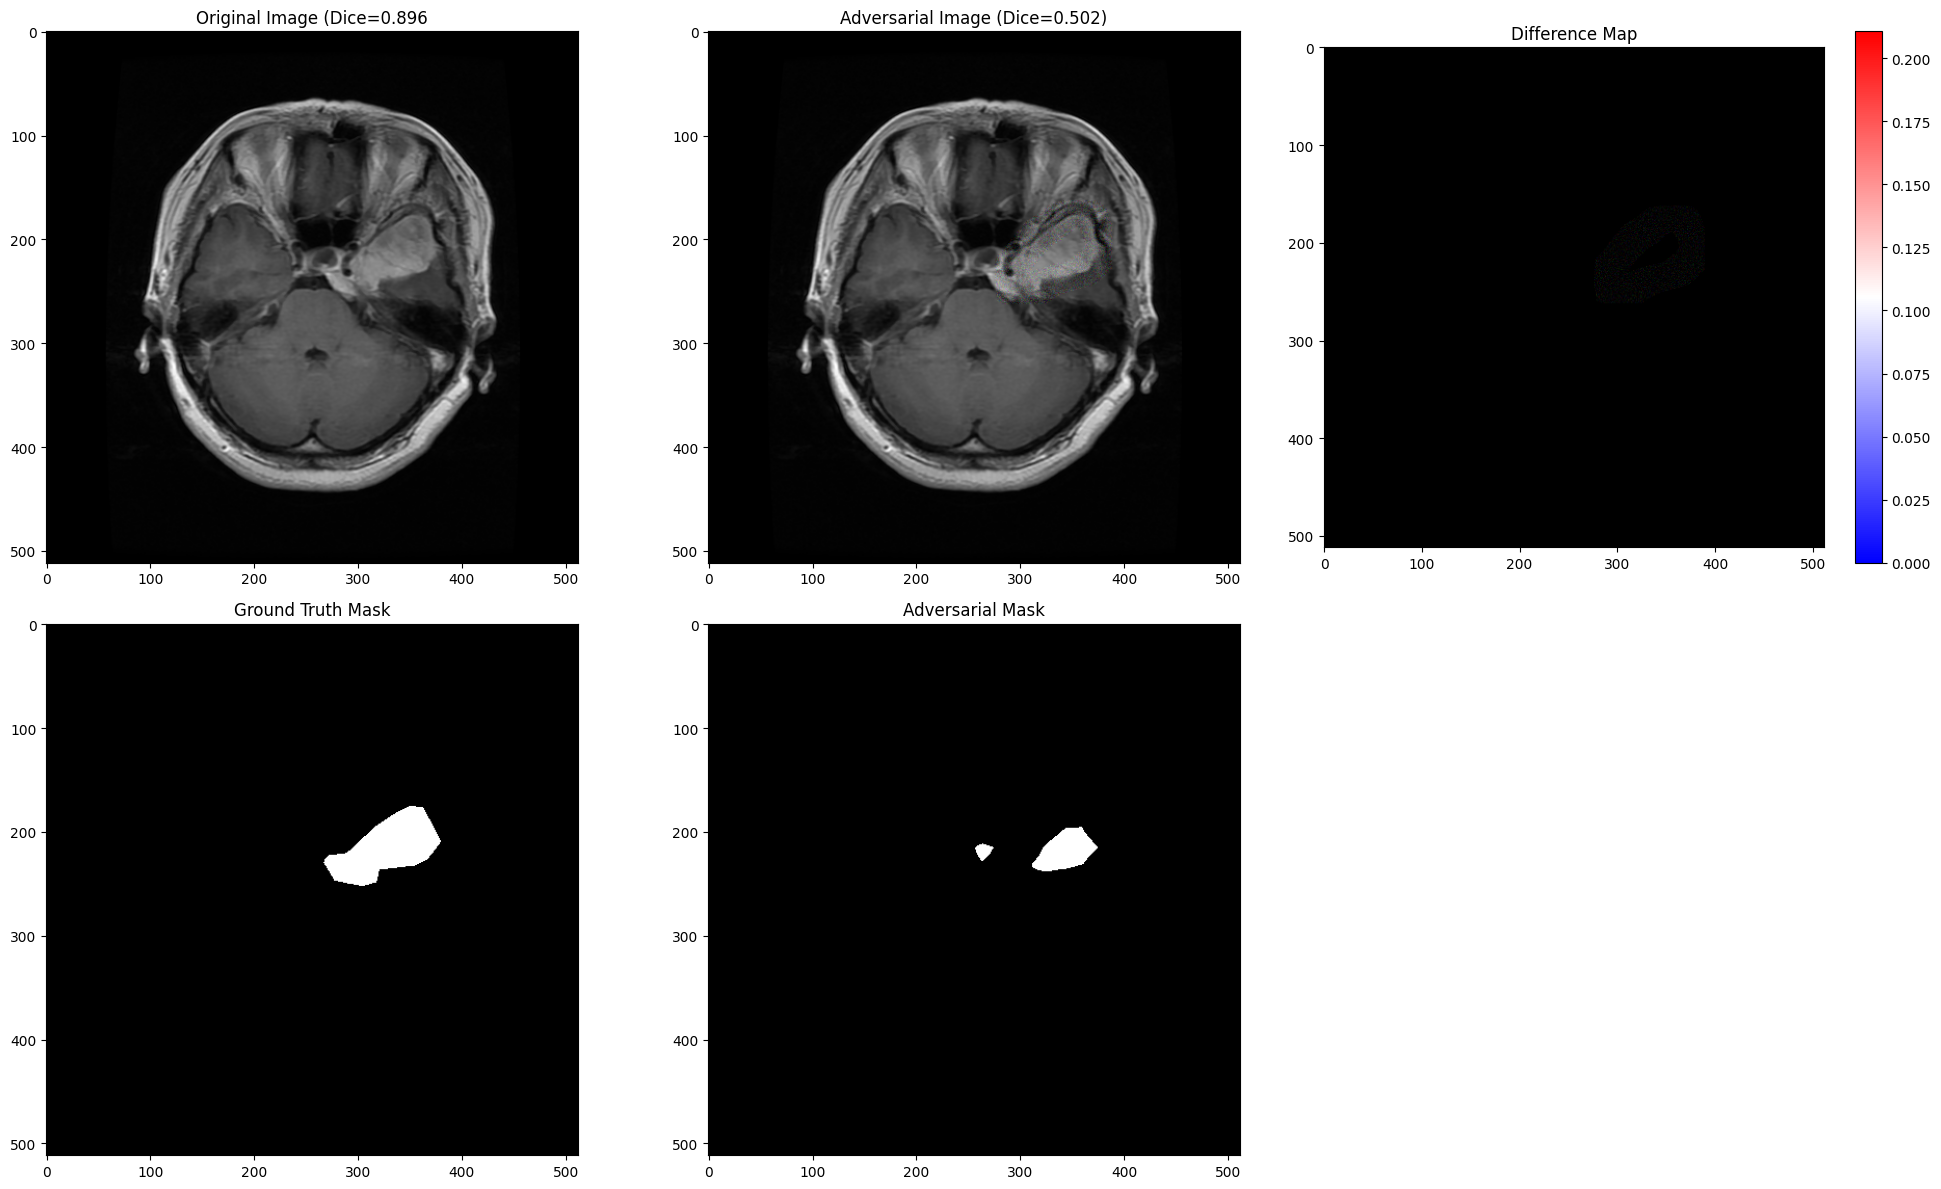

Baseline Dice: 0.9480
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Step 10/10: dice=0.9307, ssim=0.981, feat_diff=0.000000, total_score=-0.930738
Final Adversarial Dice: 0.9221 (Baseline was 0.9480)


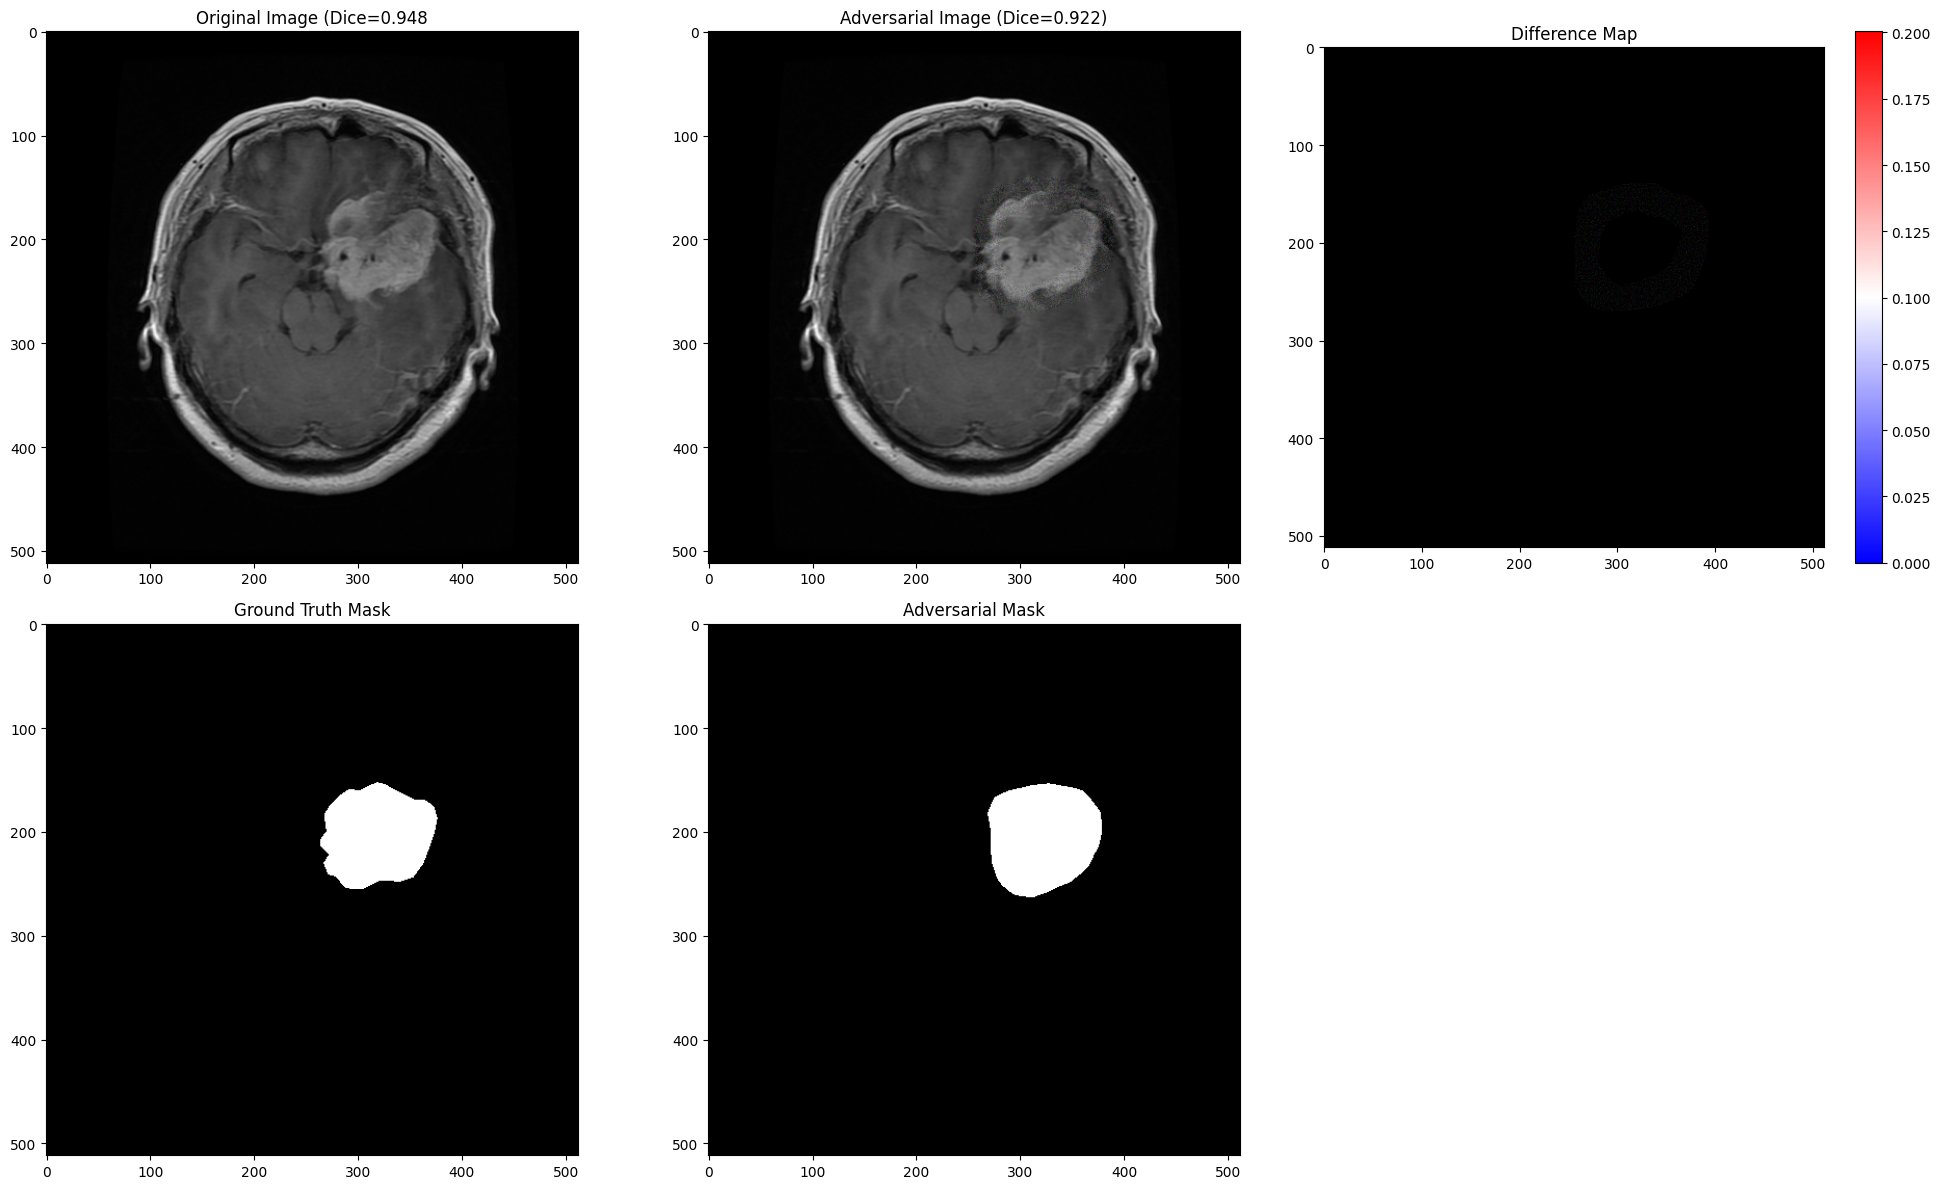

Baseline Dice: 0.9664
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Step 10/10: dice=0.9002, ssim=0.978, feat_diff=0.000000, total_score=-0.900234
Final Adversarial Dice: 0.8885 (Baseline was 0.9664)


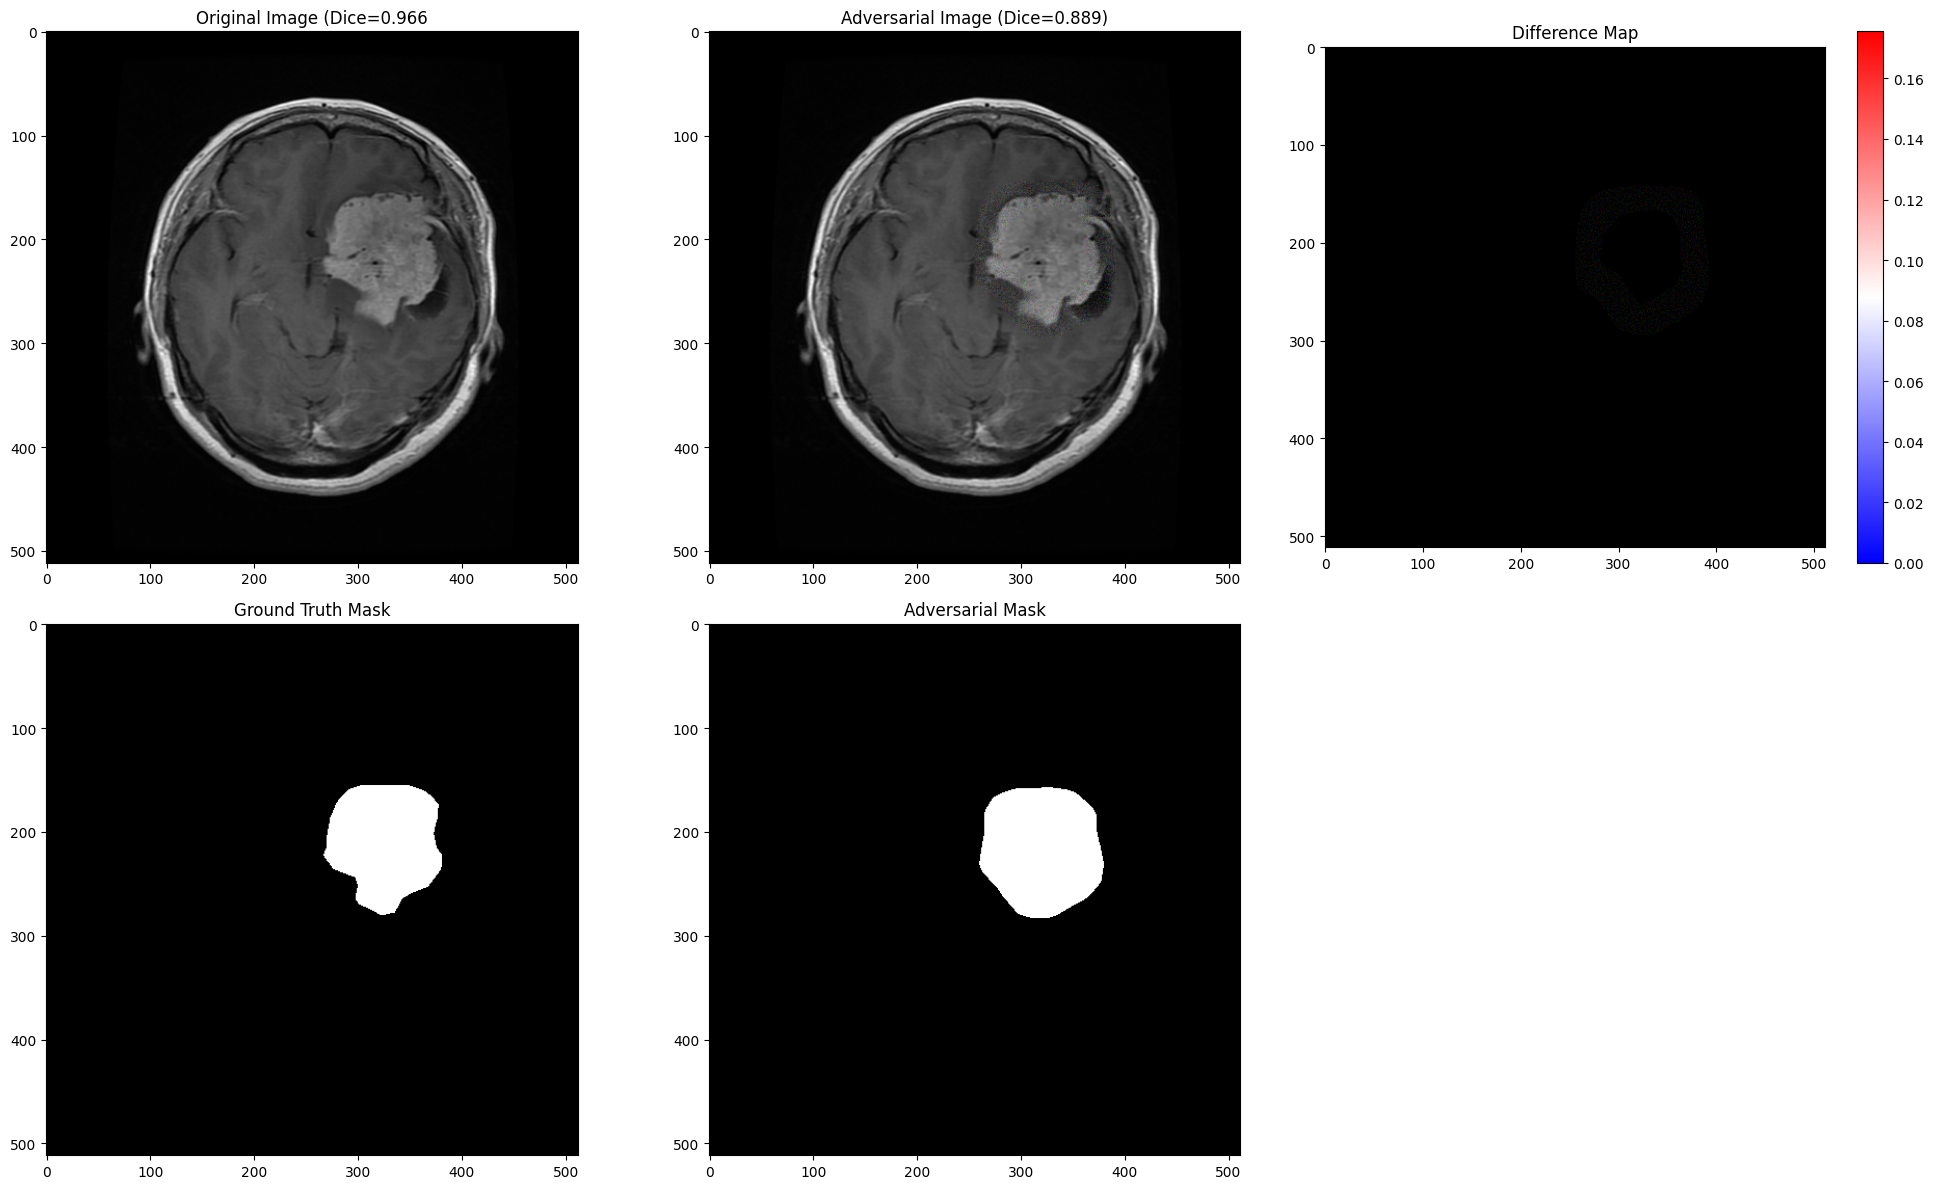

Baseline Dice: 0.9230
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Step 10/10: dice=0.7949, ssim=0.978, feat_diff=0.000001, total_score=-0.794903
Final Adversarial Dice: 0.7683 (Baseline was 0.9230)


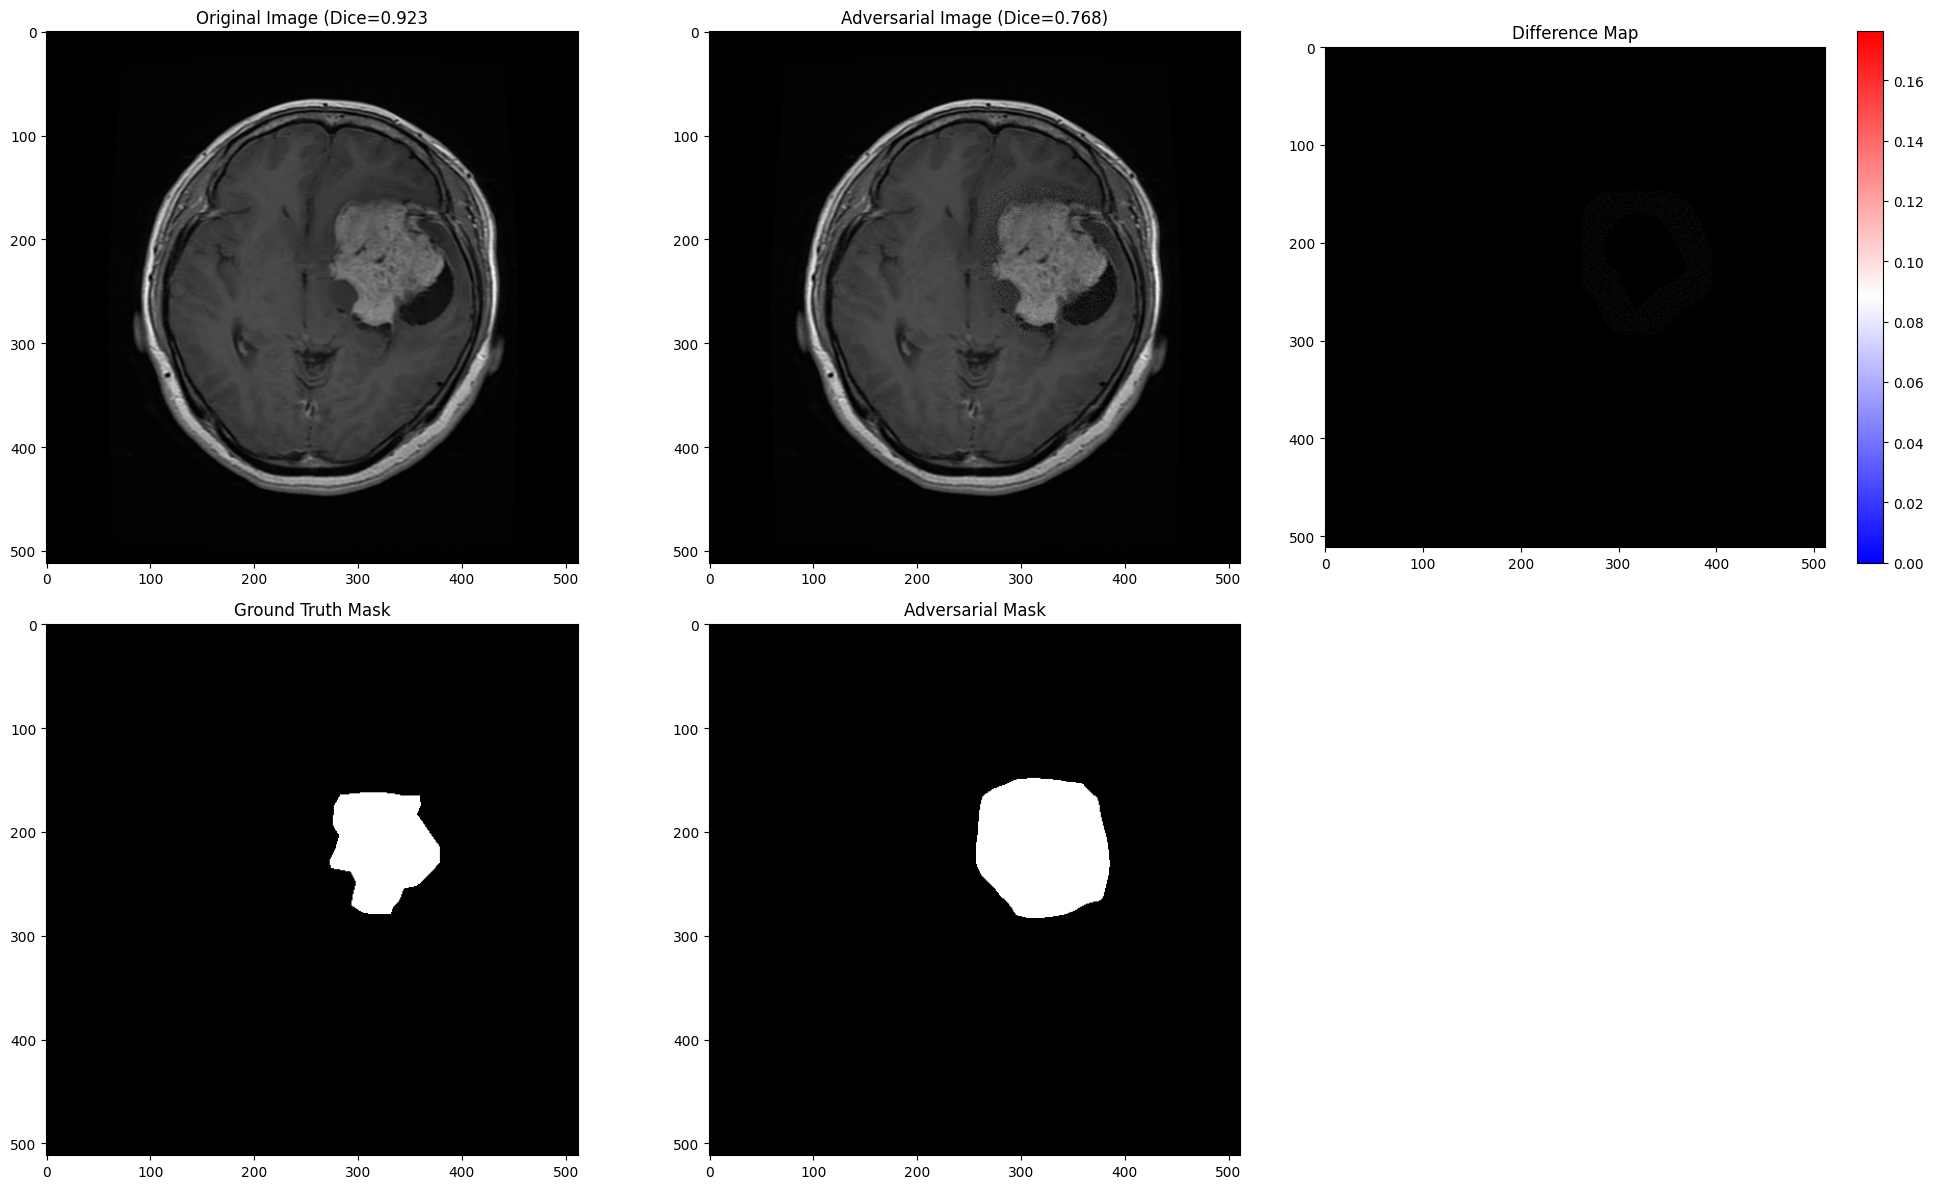

Baseline Dice: 0.8987
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Step 10/10: dice=0.8621, ssim=0.978, feat_diff=0.000001, total_score=-0.862087
Final Adversarial Dice: 0.8502 (Baseline was 0.8987)


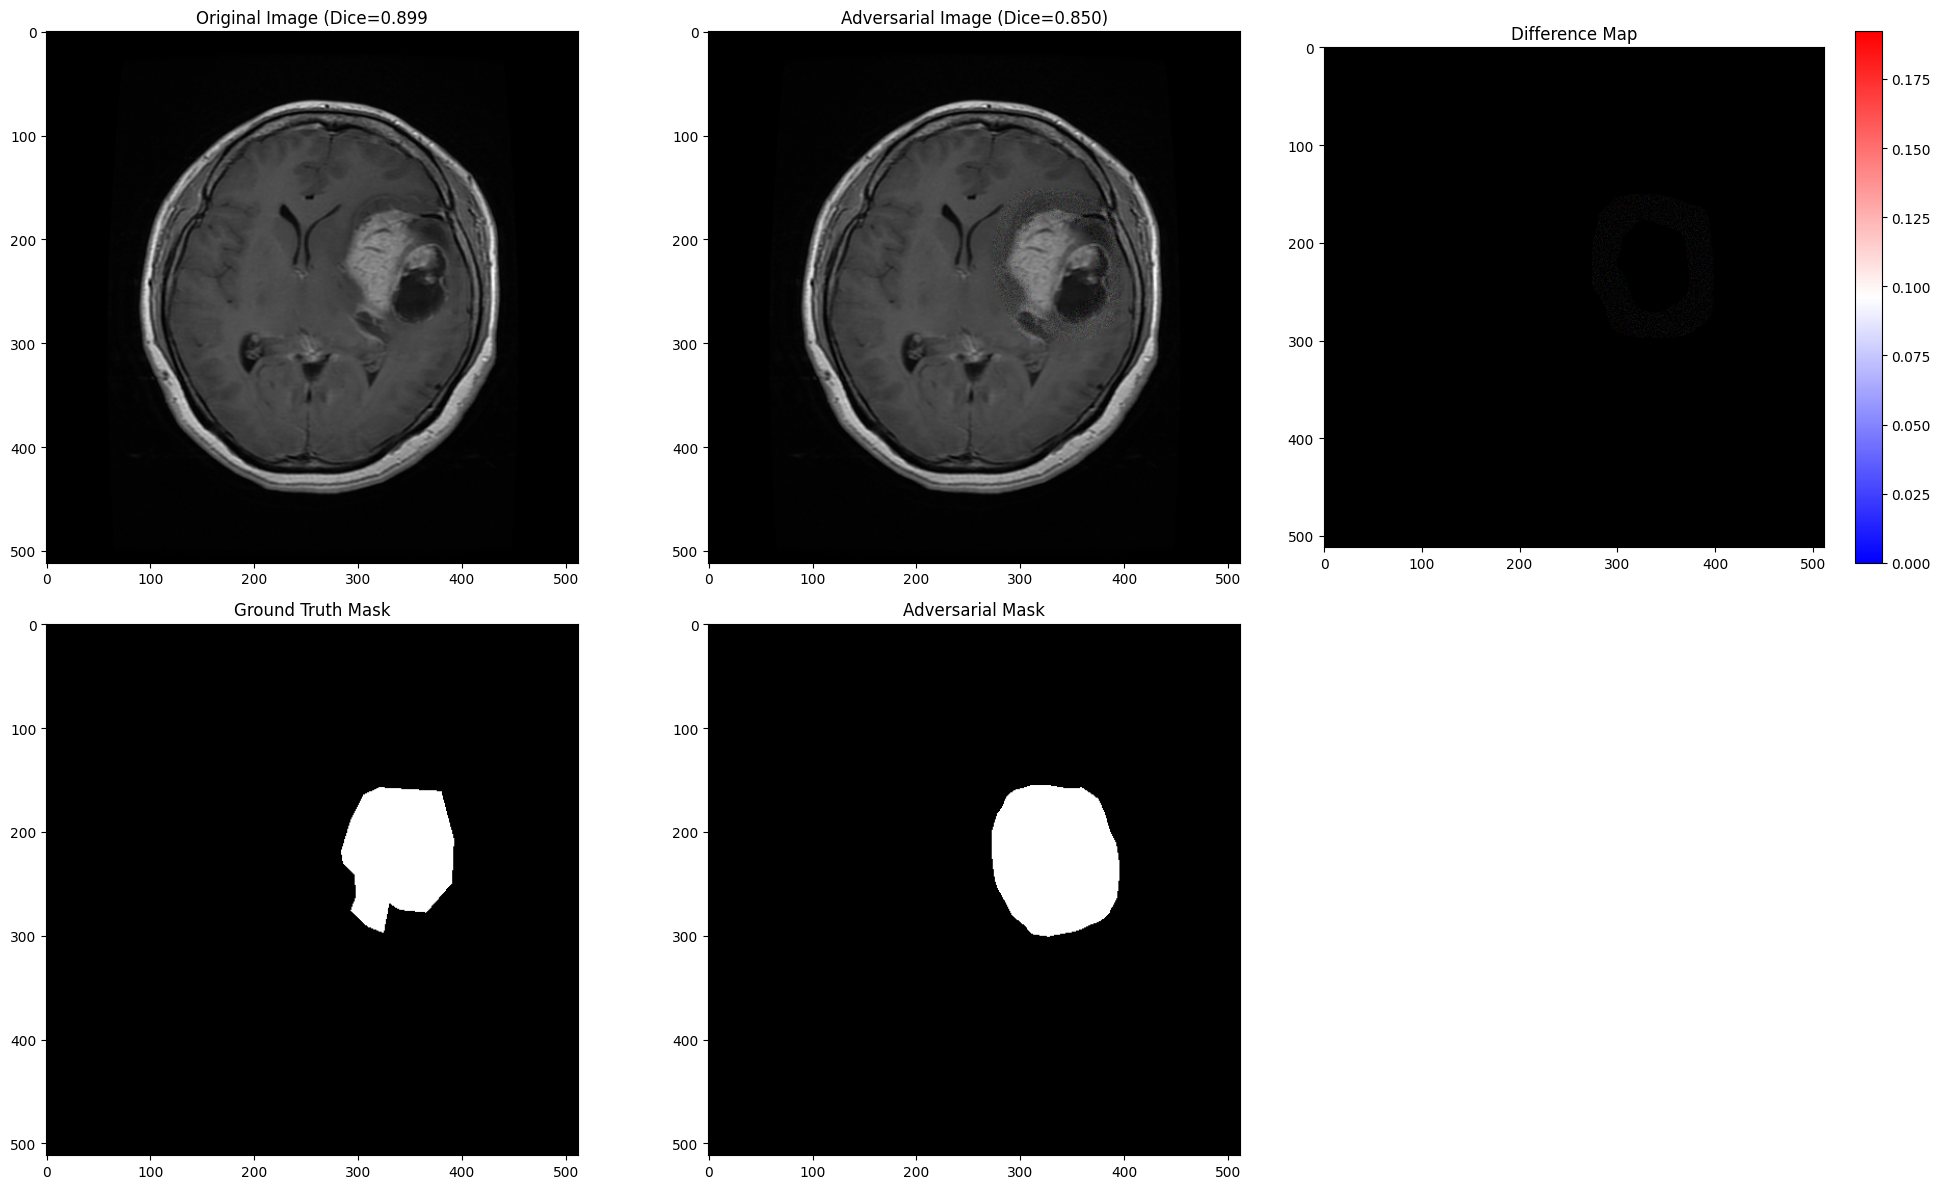

Baseline Dice: 0.9126
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Step 10/10: dice=0.9148, ssim=0.993, feat_diff=0.000000, total_score=-0.914831
Final Adversarial Dice: 0.9095 (Baseline was 0.9126)


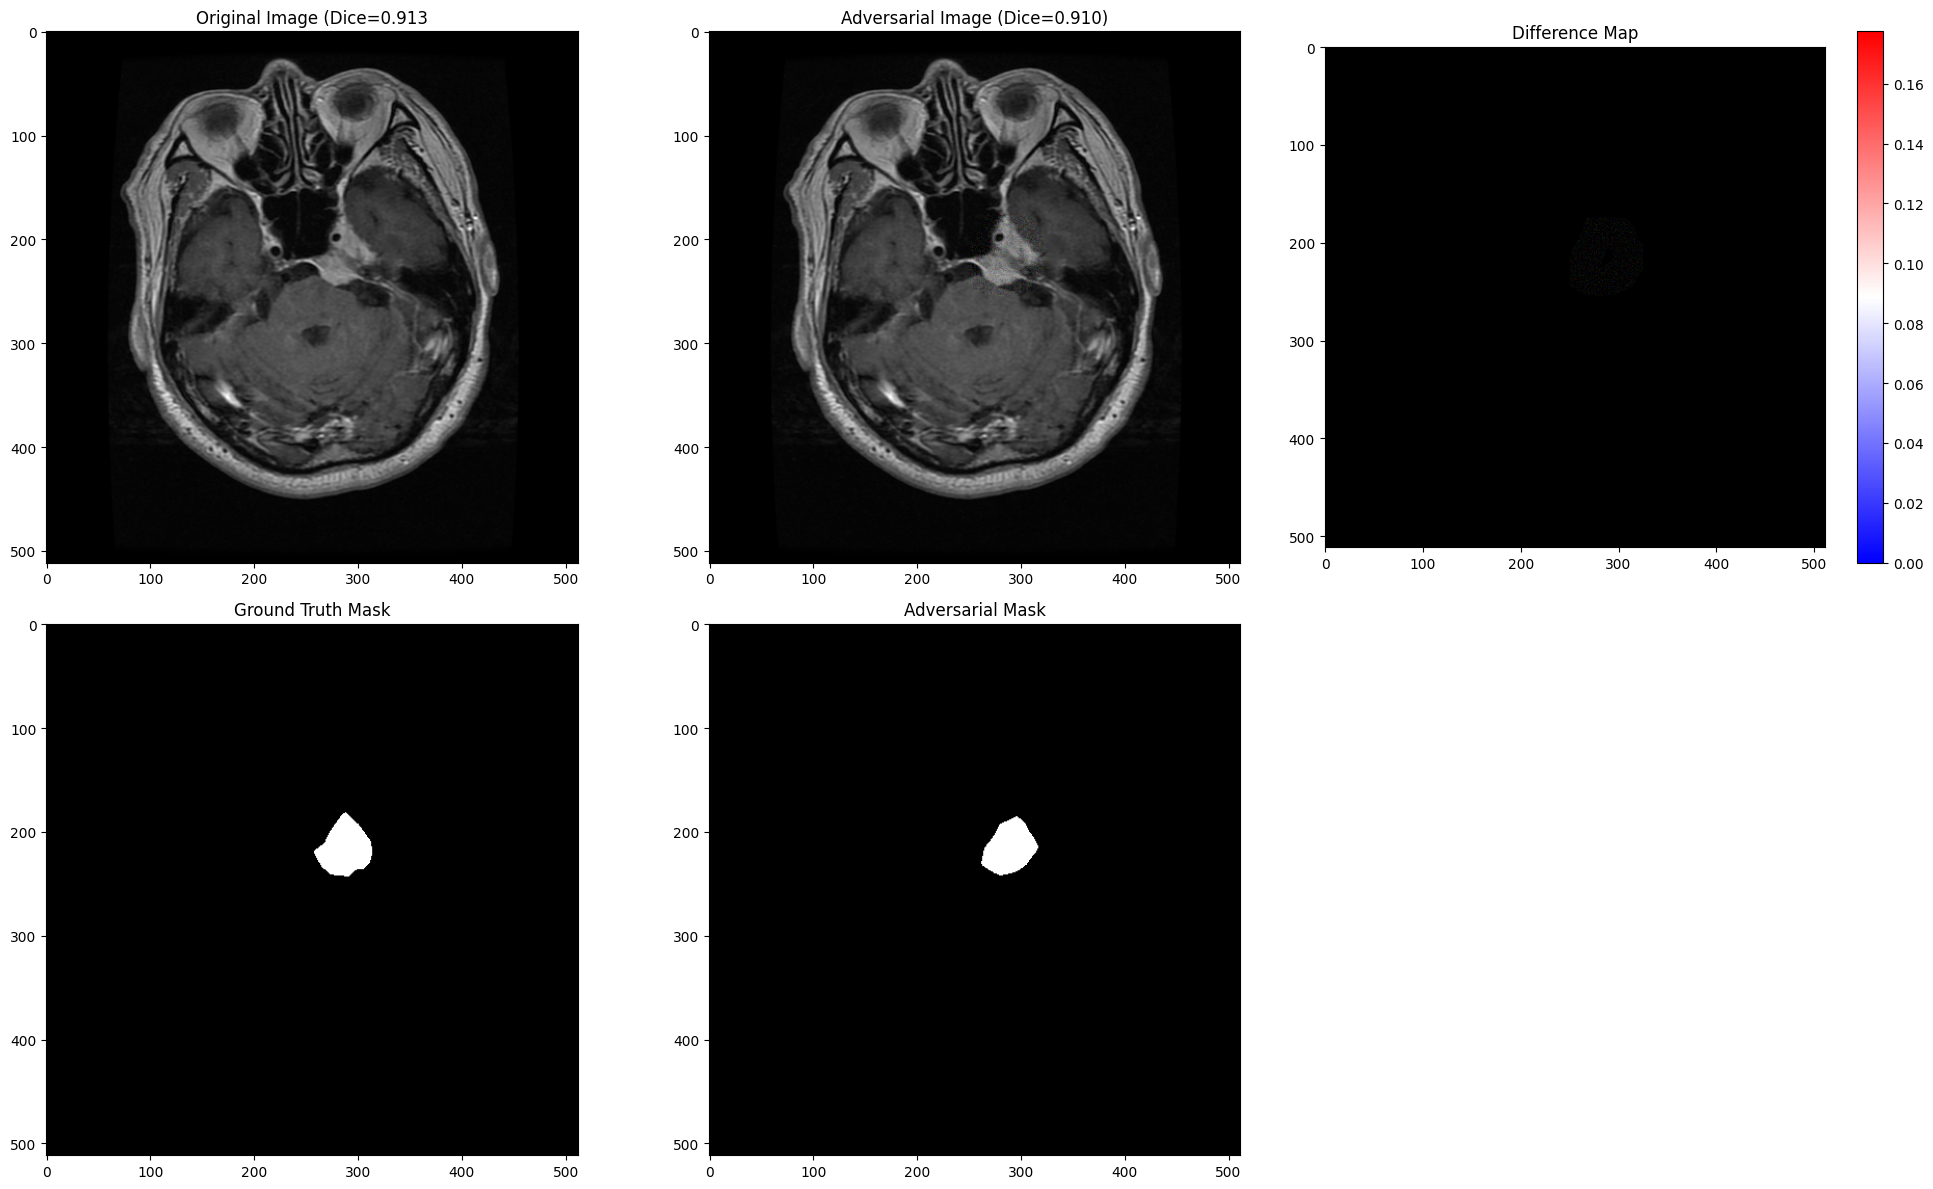

Baseline Dice: 0.9107
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Step 10/10: dice=0.8867, ssim=0.992, feat_diff=0.000000, total_score=-0.886668
Final Adversarial Dice: 0.8826 (Baseline was 0.9107)


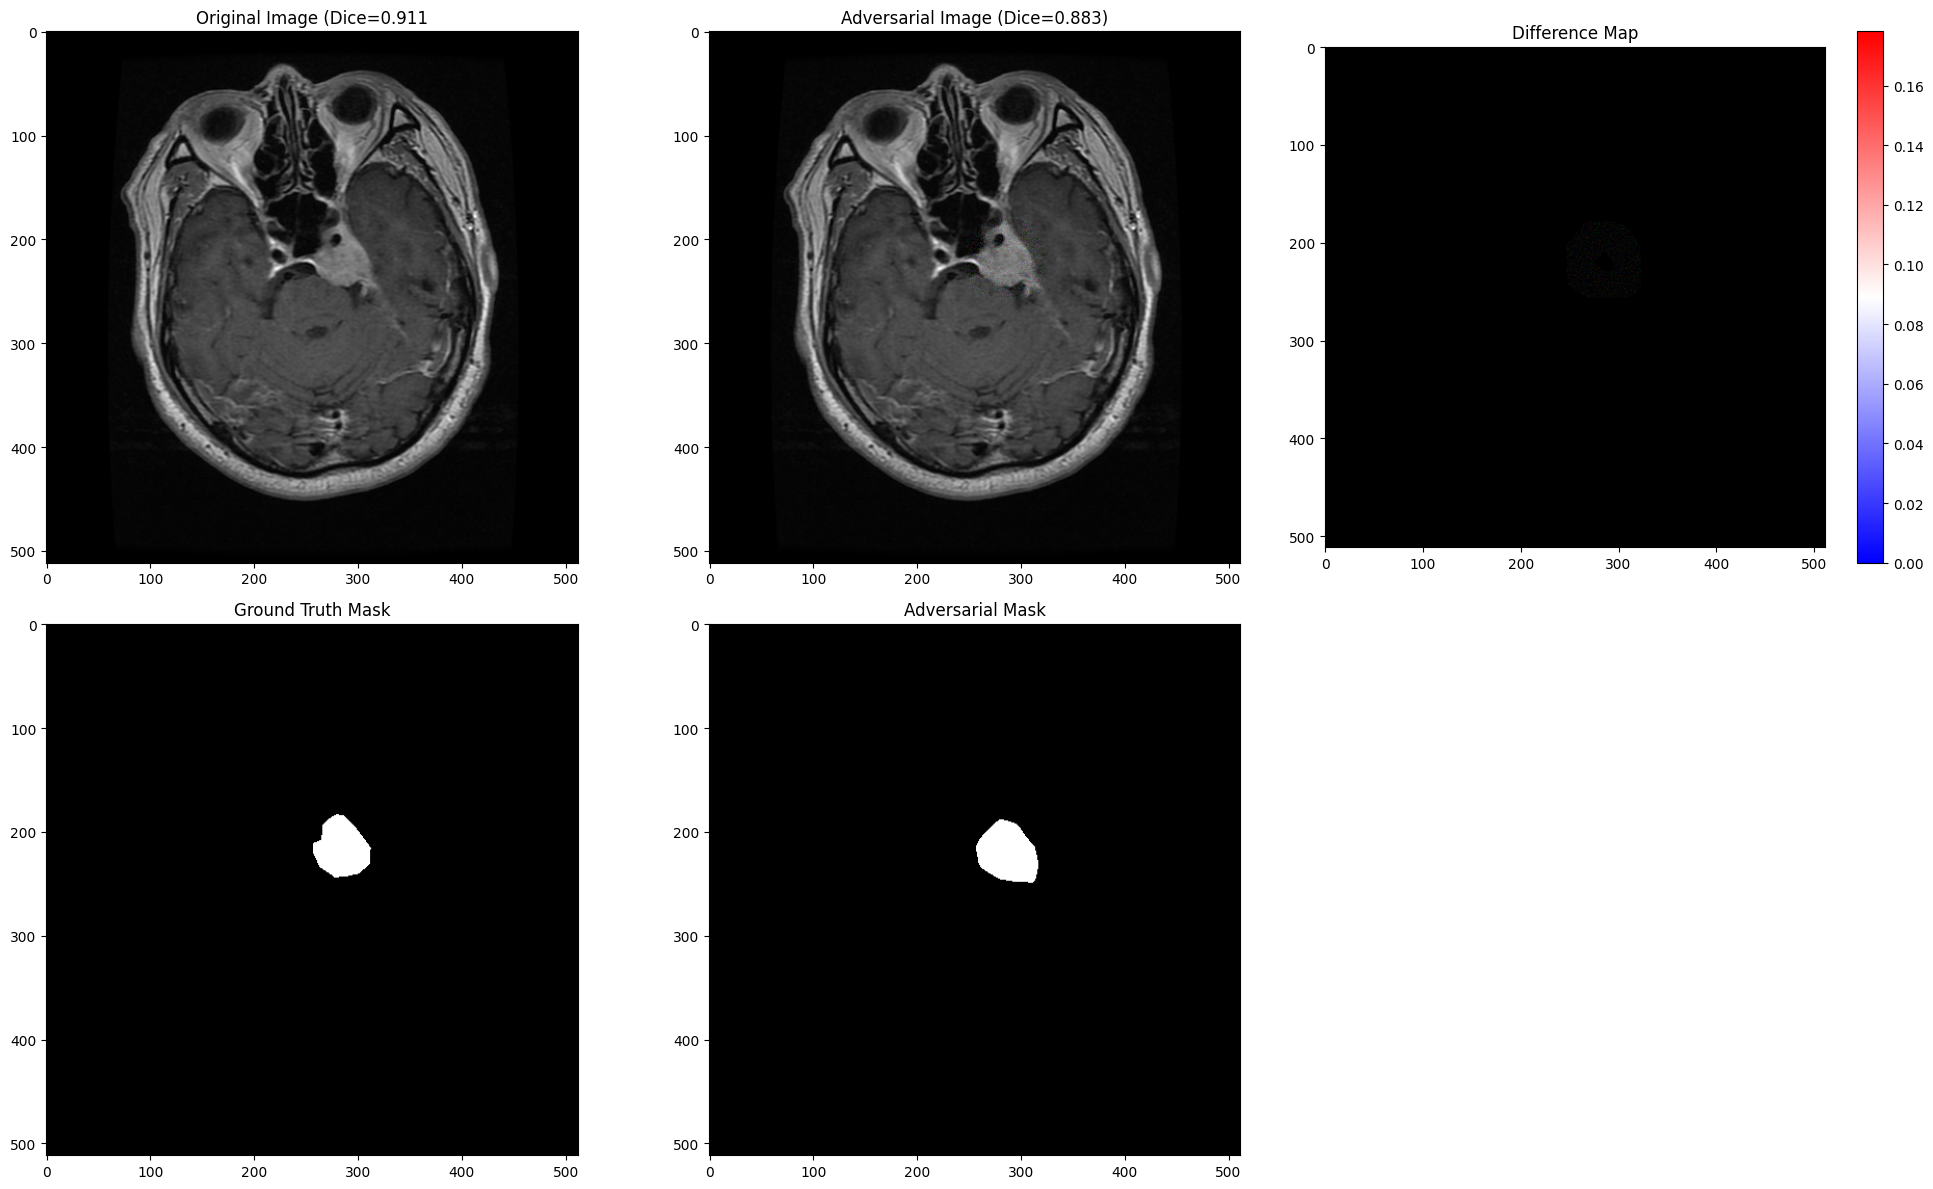

Baseline Dice: 0.8801
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Step 10/10: dice=0.8163, ssim=0.993, feat_diff=0.000000, total_score=-0.816336
Final Adversarial Dice: 0.6500 (Baseline was 0.8801)


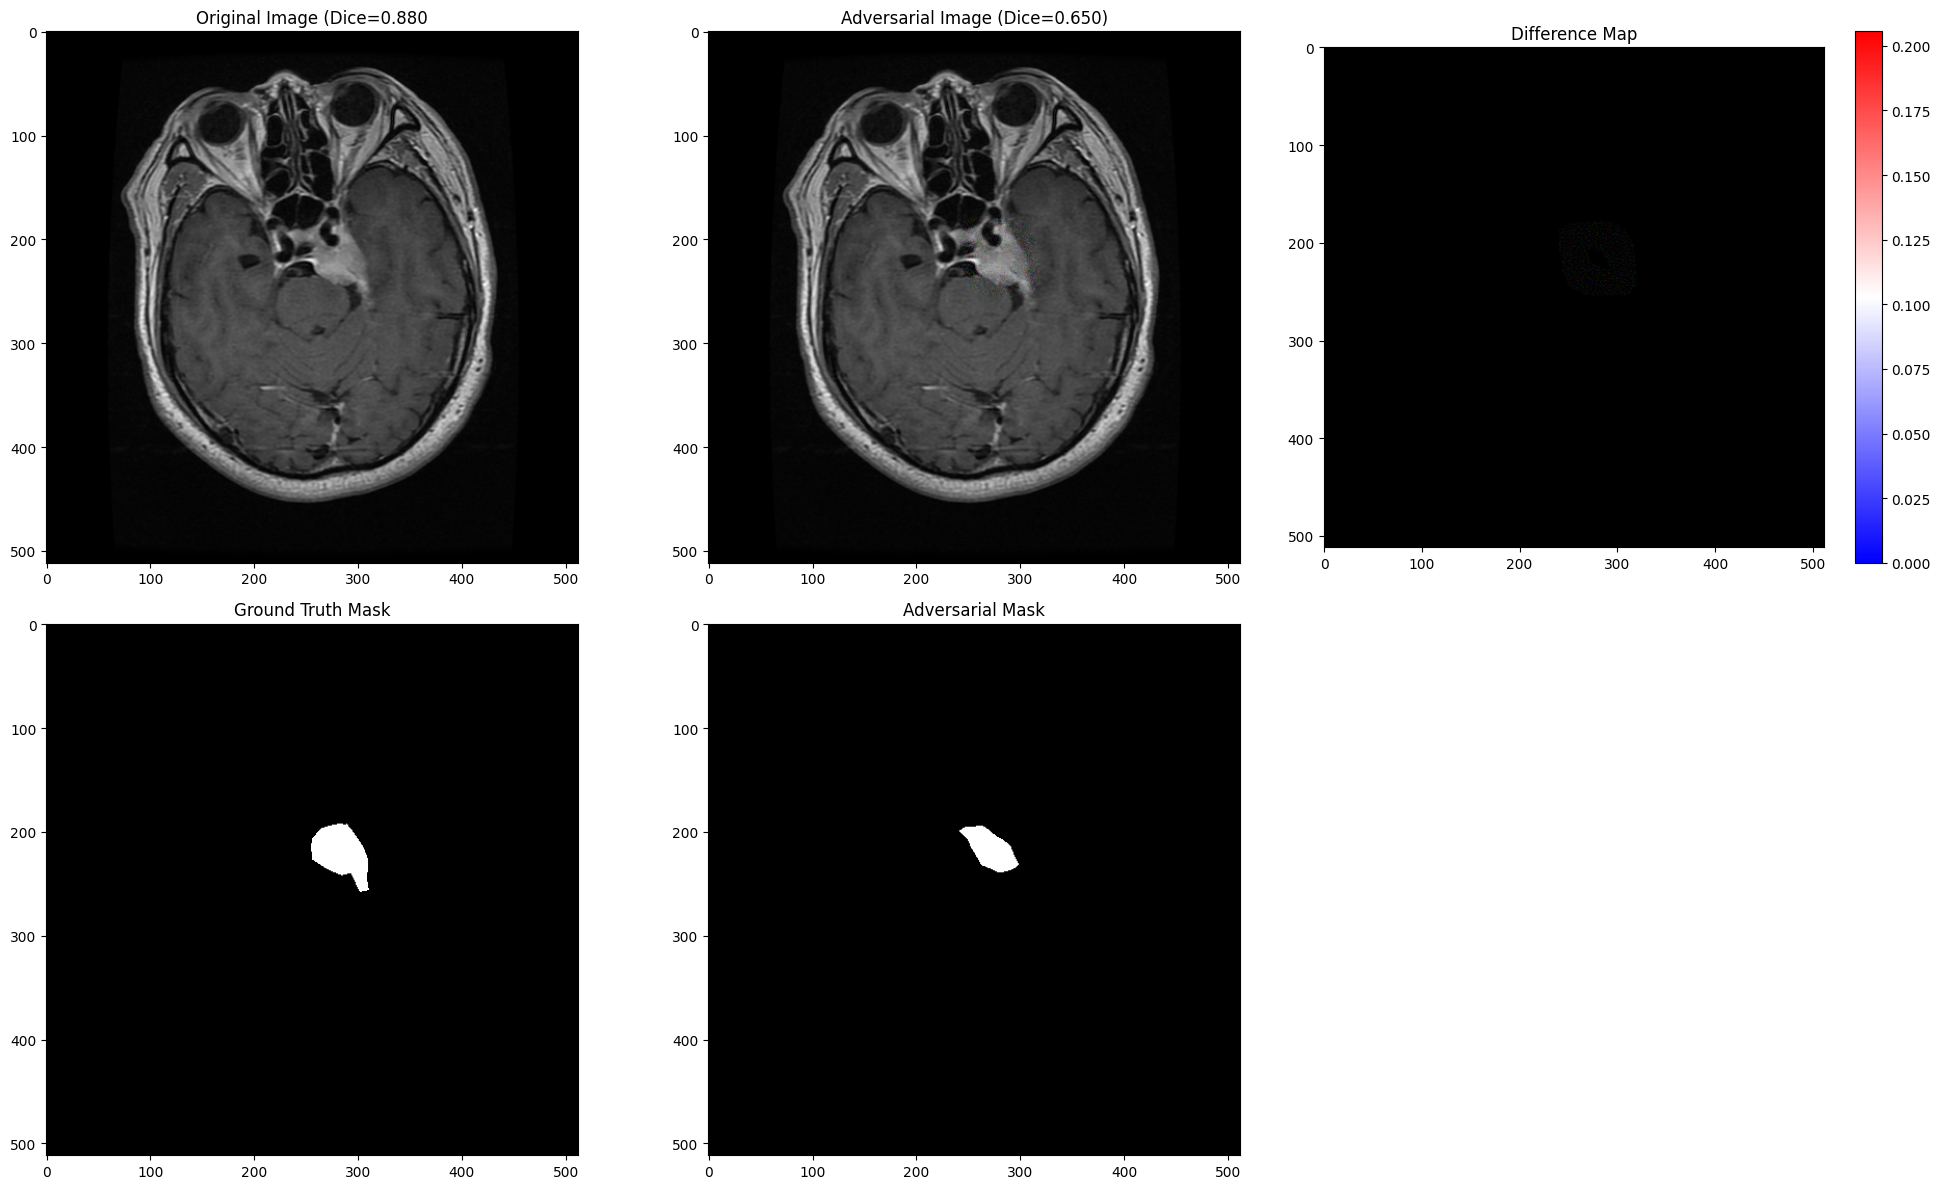

Baseline Dice: 0.8176
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Step 10/10: dice=0.6314, ssim=0.985, feat_diff=0.000000, total_score=-0.631389
Final Adversarial Dice: 0.6266 (Baseline was 0.8176)


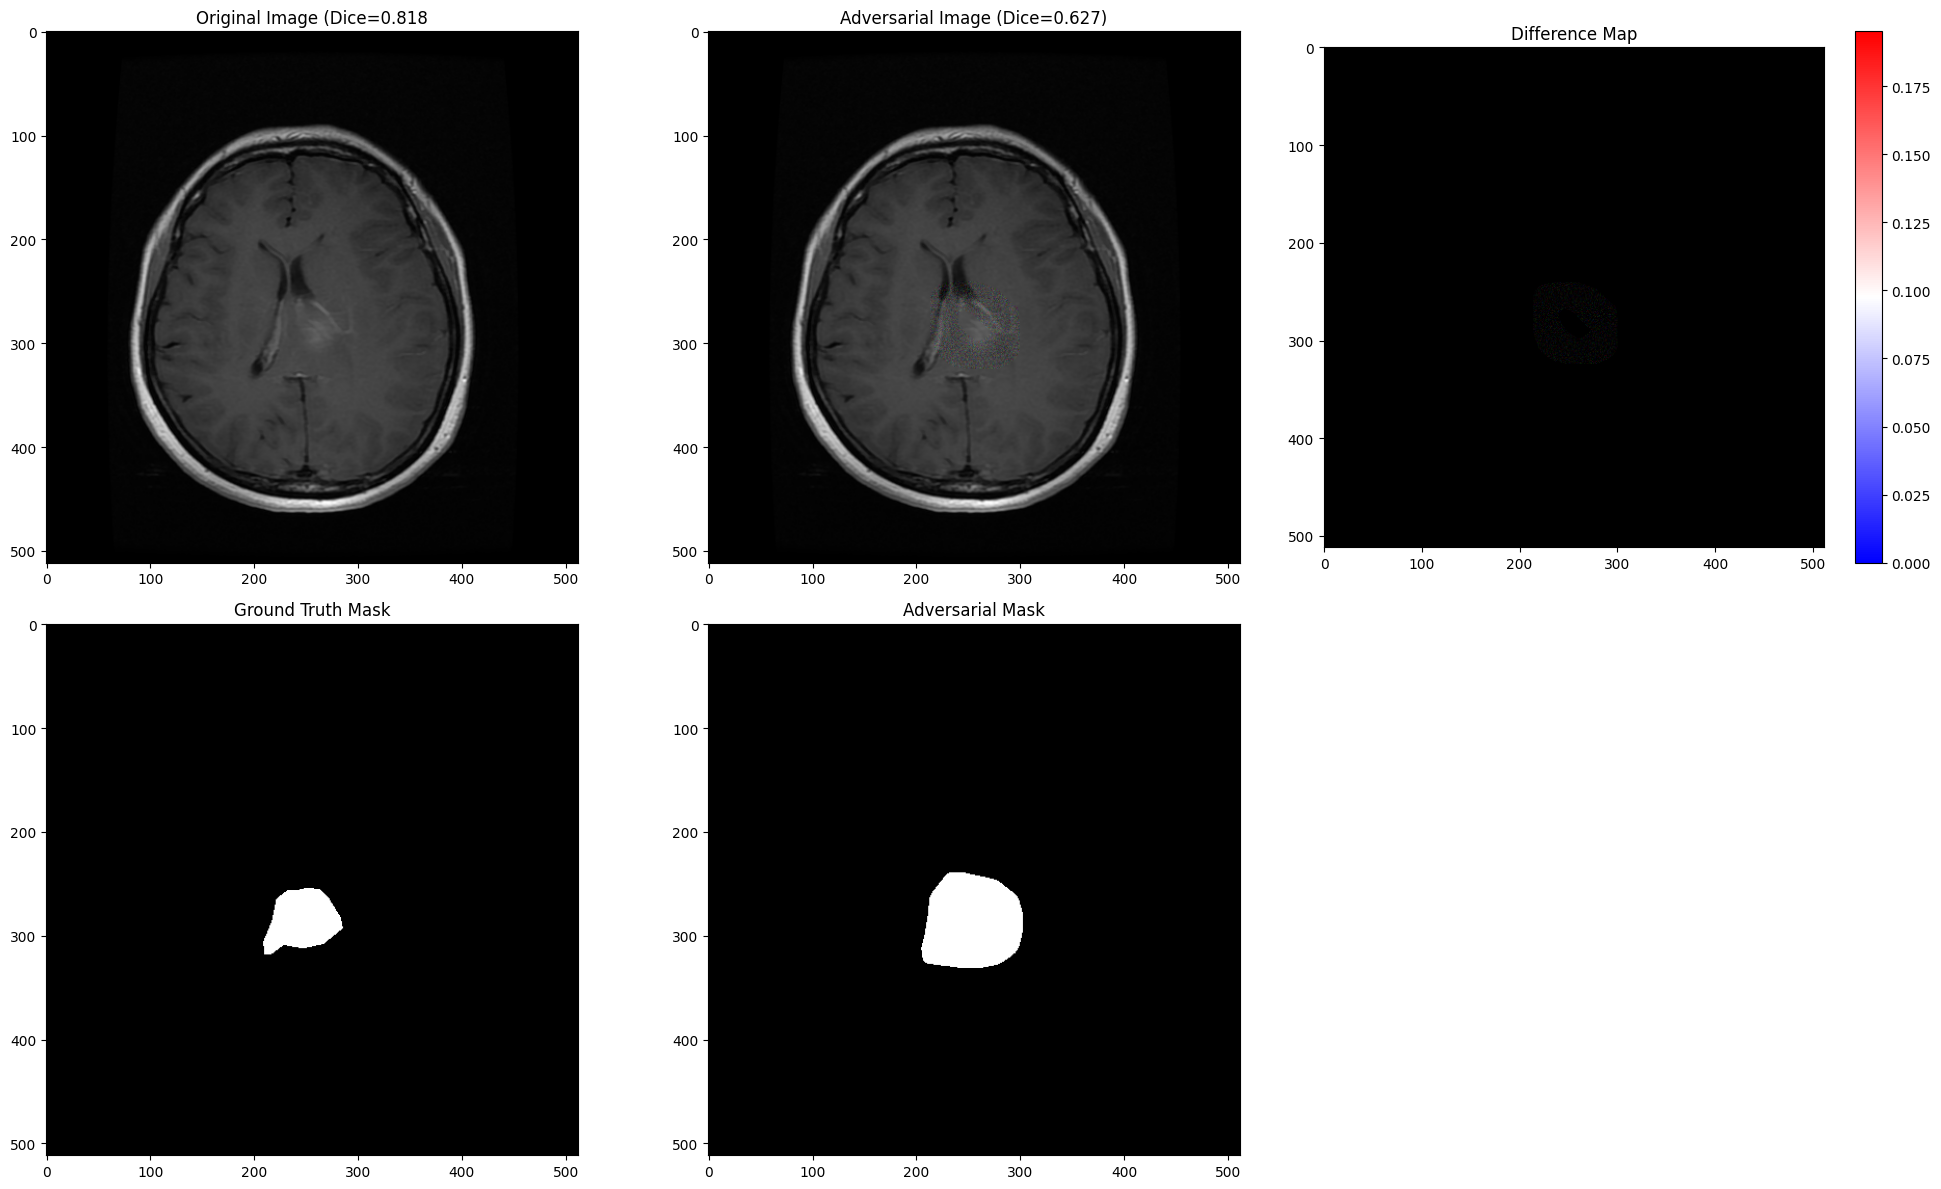

Baseline Dice: 0.9438
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Step 10/10: dice=0.5929, ssim=0.985, feat_diff=0.000001, total_score=-0.592876
Final Adversarial Dice: 0.5858 (Baseline was 0.9438)


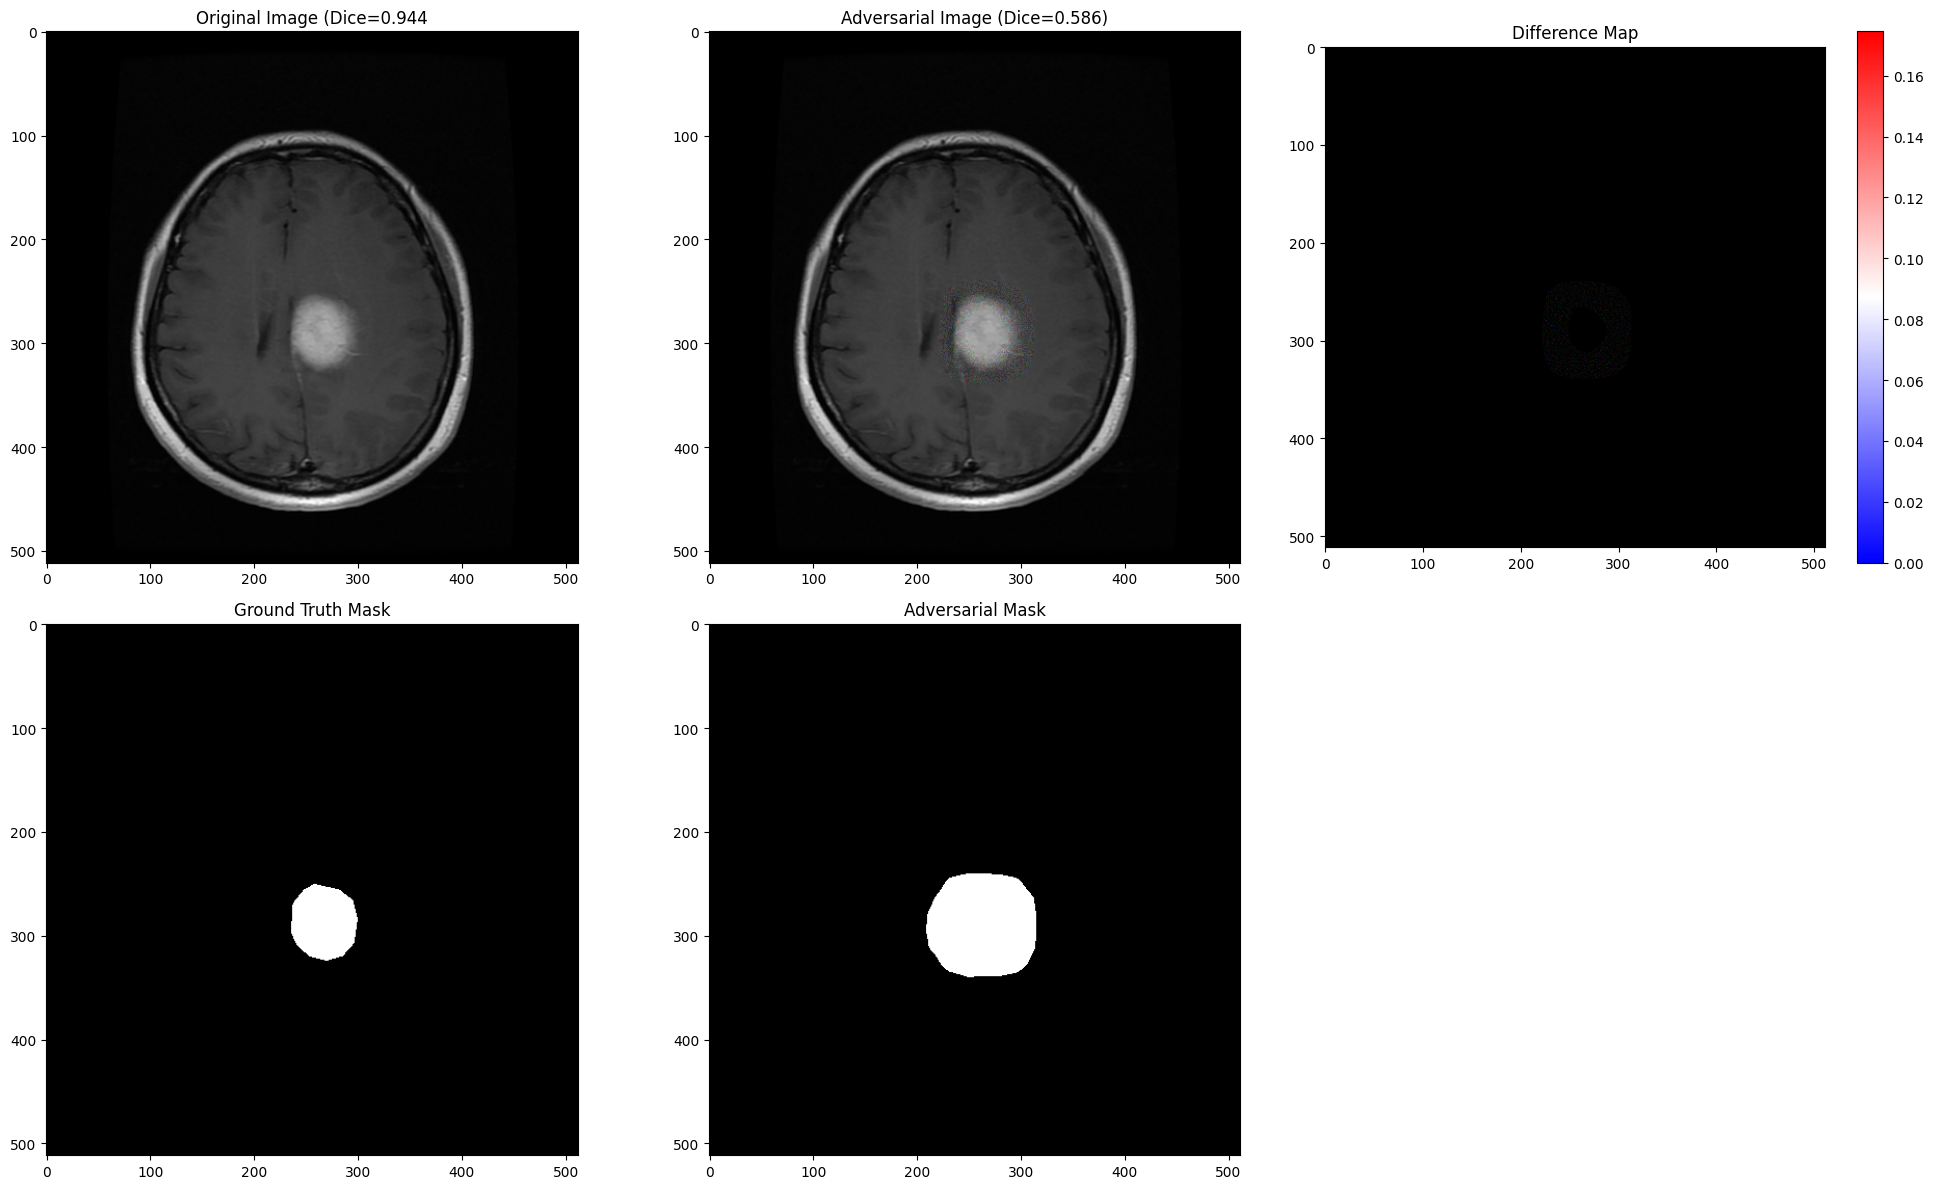

In [ ]:
img_paths = [f'/content/images/{i}.png' for i in range(1,11)]
mask_paths = [f'/content/masks/{i}.png' for i in range(1,11)]

for img_path, mask_path in zip(img_paths, mask_paths):
  orig_img_np = load_image(img_path, (512,512))
  gt_mask_np  = load_mask(mask_path, (512,512))

  # run wavelet attack
  adv_img, adv_dice = wavelet_attack_surrogate_boundary(
      orig_img_np,
      gt_mask_np,
      blackbox_model=blackbox_model,
      surrogate_feature_extractor=feature_extractor,
      steps=10,
      alpha=0.05,
      ssim_thresh=0.70,
      feat_weight=5.0,
      kernel_size=9
  )

  # Compute the adversarial mask from the adversarial image
  adv_mask = query_deeplab(blackbox_model, adv_img)
  base_pred = query_deeplab(blackbox_model, orig_img_np)
  base_dice = dice_np(base_pred, gt_mask_np)

  plt.figure(figsize=(20,12))
  plt.subplot(231)
  plt.imshow(orig_img_np)
  plt.title(f'Original Image (Dice={base_dice:.3f}')

  plt.subplot(232)
  plt.imshow(adv_img)
  plt.title(f'Adversarial Image (Dice={adv_dice:.3f})')

  plt.subplot(233)
  diff = adv_img - orig_img_np
  plt.imshow(diff, cmap='bwr')
  plt.title('Difference Map')
  plt.colorbar()

  plt.subplot(234)
  plt.imshow(gt_mask_np, cmap='gray')
  plt.title('Ground Truth Mask')

  plt.subplot(235)
  plt.imshow(adv_mask, cmap='gray')
  plt.title('Adversarial Mask')

  plt.tight_layout()
  plt.show()